In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [17]:

# Load dataset
df = pd.read_csv('/content/dataset_1.csv')

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Drop any rows with missing values
df.dropna(inplace=True)


Missing values:
 miRNA_isomiR    0
mRNA            0
label           0
dtype: int64


In [18]:
# Convert sequences to uppercase
df["miRNA_isomiR"] = df["miRNA_isomiR"].str.upper()
df["mRNA"] = df["mRNA"].str.upper()

# Function to filter valid RNA sequences (A, U, G, C only)
def valid_rna(seq):
    return re.fullmatch(r"[AUGC]+", seq) is not None

# Filter out invalid sequences
df = df[df["miRNA_isomiR"].apply(valid_rna) & df["mRNA"].apply(valid_rna)]

# Remove duplicates
df.drop_duplicates(inplace=True)

# Show dataset info after preprocessing
print("Dataset after preprocessing:\n", df.info())

# Show label distribution
print("Updated Label Distribution:\n", df["label"].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 79491 to 311682
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   miRNA_isomiR  8 non-null      object
 1   mRNA          8 non-null      object
 2   label         8 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 256.0+ bytes
Dataset after preprocessing:
 None
Updated Label Distribution:
 label
1    8
Name: count, dtype: int64


<ipython-input-18-77a4f243b2c8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


In [19]:
# Function to encode RNA sequences
rna_mapping = {'A': 1, 'U': 2, 'G': 3, 'C': 4}

# Encode RNA sequences
def encode_rna_sequence(seq):
    return [rna_mapping[n] for n in seq]

df["miRNA_isomiR_encoded"] = df["miRNA_isomiR"].apply(encode_rna_sequence)
df["mRNA_encoded"] = df["mRNA"].apply(encode_rna_sequence)

# Find max sequence lengths
max_len_miRNA = max(df["miRNA_isomiR_encoded"].apply(len))
max_len_mRNA = max(df["mRNA_encoded"].apply(len))

# Pad sequences to the max length
df["miRNA_isomiR_encoded"] = pad_sequences(df["miRNA_isomiR_encoded"], maxlen=max_len_miRNA, padding='post').tolist()
df["mRNA_encoded"] = pad_sequences(df["mRNA_encoded"], maxlen=max_len_mRNA, padding='post').tolist()

# Extract features (encoded sequences) and labels
X_miRNA = np.array(df["miRNA_isomiR_encoded"].tolist())
X_mRNA = np.array(df["mRNA_encoded"].tolist())
y = df["label"].values

In [20]:

# Split into training (80%) and testing (20%) sets
X_miRNA_train, X_miRNA_test, X_mRNA_train, X_mRNA_test, y_train, y_test = train_test_split(
    X_miRNA, X_mRNA, y, test_size=0.2, stratify=y, random_state=42
)


In [21]:
# Apply GC content and length calculations
def gc_content(seq):
    return (seq.count('G') + seq.count('C')) / len(seq)

def kmer_frequencies(seq, k=2):
    kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
    unique_kmers = set(kmers)
    return {kmer: kmers.count(kmer) / len(kmers) for kmer in unique_kmers}

df["miRNA_GC"] = df["miRNA_isomiR"].apply(gc_content)
df["mRNA_GC"] = df["mRNA"].apply(gc_content)
df["miRNA_length"] = df["miRNA_isomiR"].apply(len)
df["mRNA_length"] = df["mRNA"].apply(len)

df["miRNA_kmer"] = df["miRNA_isomiR"].apply(lambda x: kmer_frequencies(x, k=2))
df["mRNA_kmer"] = df["mRNA"].apply(lambda x: kmer_frequencies(x, k=2))

# Stack the GC content and k-mer features
gc_features = np.stack([df["miRNA_GC"].values, df["mRNA_GC"].values], axis=1)
kmer_features = np.stack([df["miRNA_kmer"].apply(lambda x: list(x.values())).values,
                          df["mRNA_kmer"].apply(lambda x: list(x.values())).values], axis=1)

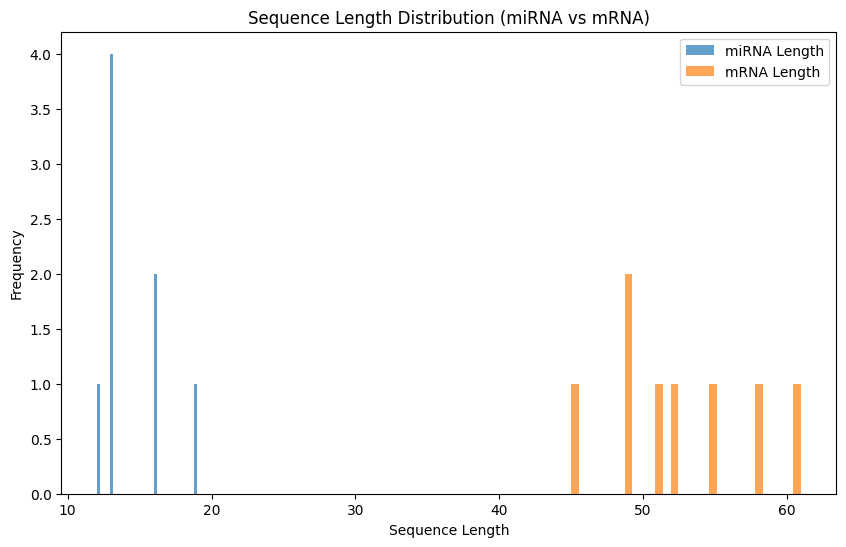

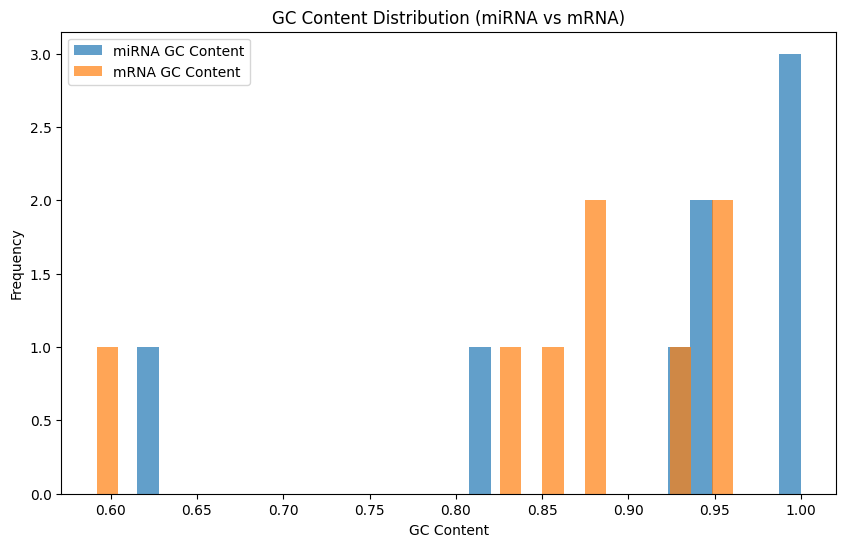

In [22]:
# Combine the encoded miRNA, mRNA sequences, GC content, and k-mer frequencies
X_miRNA_final = np.array(df["miRNA_isomiR_encoded"].tolist())
X_mRNA_final = np.array(df["mRNA_encoded"].tolist())

# Final input tensor (concatenated)
X_final = np.concatenate([X_miRNA_final, X_mRNA_final, gc_features, kmer_features], axis=1)

# Labels
y_final = df["label"].values

# Plot sequence length distributions
plt.figure(figsize=(10, 6))
plt.hist(df["miRNA_length"], bins=30, alpha=0.7, label="miRNA Length")
plt.hist(df["mRNA_length"], bins=30, alpha=0.7, label="mRNA Length")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.legend()
plt.title("Sequence Length Distribution (miRNA vs mRNA)")
plt.show()

# Plot GC content distributions
plt.figure(figsize=(10, 6))
plt.hist(df["miRNA_GC"], bins=30, alpha=0.7, label="miRNA GC Content")
plt.hist(df["mRNA_GC"], bins=30, alpha=0.7, label="mRNA GC Content")
plt.xlabel("GC Content")
plt.ylabel("Frequency")
plt.legend()
plt.title("GC Content Distribution (miRNA vs mRNA)")
plt.show()

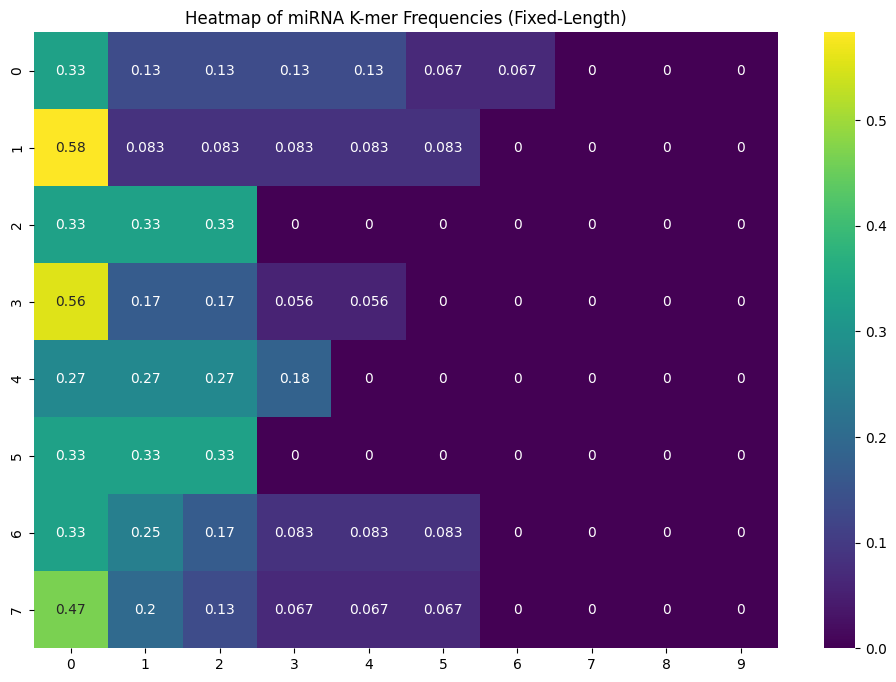

In [26]:
# Function to extract k-mer frequencies and normalize them to a fixed-length vector
def kmer_frequencies_fixed_length(seq, k=2, top_n=10):
    kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
    kmer_count = {}
    for kmer in kmers:
        kmer_count[kmer] = kmer_count.get(kmer, 0) + 1

    # Sort kmers by frequency and take the top_n most frequent
    sorted_kmers = sorted(kmer_count.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Create a fixed-length vector (size: top_n)
    fixed_kmer_vector = [0] * top_n
    for i, (kmer, count) in enumerate(sorted_kmers):
        fixed_kmer_vector[i] = count / len(kmers)  # Normalize by total k-mers count

    return fixed_kmer_vector

# Apply the function to generate fixed-length k-mer feature vectors
df["miRNA_kmer_fixed"] = df["miRNA_isomiR"].apply(lambda x: kmer_frequencies_fixed_length(x, k=2, top_n=10))
df["mRNA_kmer_fixed"] = df["mRNA"].apply(lambda x: kmer_frequencies_fixed_length(x, k=2, top_n=10))

# Stack the GC content and k-mer features
gc_features = np.stack([df["miRNA_GC"].values, df["mRNA_GC"].values], axis=1)
kmer_features = np.stack([df["miRNA_kmer_fixed"].values, df["mRNA_kmer_fixed"].values], axis=1)

# Combine the encoded miRNA, mRNA sequences, GC content, and k-mer frequencies
X_miRNA_final = np.array(df["miRNA_isomiR_encoded"].tolist())
X_mRNA_final = np.array(df["mRNA_encoded"].tolist())

# Final input tensor (concatenated)
X_final = np.concatenate([X_miRNA_final, X_mRNA_final, gc_features, kmer_features], axis=1)

# Labels
y_final = df["label"].values

# For visualization, let's try plotting the fixed-length k-mer features
kmer_matrix = np.array([list(x) for x in df["miRNA_kmer_fixed"]])
plt.figure(figsize=(12, 8))
sns.heatmap(kmer_matrix, cmap="viridis", annot=True)
plt.title("Heatmap of miRNA K-mer Frequencies (Fixed-Length)")
plt.show()


In [27]:
# Define transformer_encoder function
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

# Define the model architecture
miRNA_input = layers.Input(shape=(max_len,))
mRNA_input = layers.Input(shape=(max_len,))

miRNA_embedding = layers.Embedding(input_dim=5, output_dim=64)(miRNA_input)
mRNA_embedding = layers.Embedding(input_dim=5, output_dim=64)(mRNA_input)

miRNA_conv = layers.Conv1D(128, 3, activation='relu')(miRNA_embedding)
mRNA_conv = layers.Conv1D(128, 3, activation='relu')(mRNA_embedding)

miRNA_transformer = transformer_encoder(miRNA_conv, head_size=64, num_heads=4, ff_dim=128)
mRNA_transformer = transformer_encoder(mRNA_conv, head_size=64, num_heads=4, ff_dim=128)

miRNA_pool = layers.GlobalAveragePooling1D()(miRNA_transformer)
mRNA_pool = layers.GlobalAveragePooling1D()(mRNA_transformer)

# Additional dense layers for secondary features (GC + k-mer)
additional_input = layers.Input(shape=(gc_features.shape[1] + kmer_features.shape[1],))
dense_additional = layers.Dense(64, activation='relu')(additional_input)

# Combine miRNA and mRNA features
merged = layers.concatenate([miRNA_pool, mRNA_pool], axis=-1)
combined = layers.concatenate([merged, dense_additional], axis=-1)

# Final dense layers for classification
dense1 = layers.Dense(256, activation='relu')(combined)
dense2 = layers.Dense(128, activation='relu')(dense1)
output = layers.Dense(1, activation='sigmoid')(dense2)


In [29]:
# Create and compile the model
model = models.Model(inputs=[miRNA_input, mRNA_input, additional_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 61)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 61)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 61, 64)    │        320 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 61, 64)    │        320 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 59, 128)   │     24,704 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 59, 128)   │     24,704 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 59, 128)   │        256 │ conv1d_2[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 59, 128)   │        256 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 59, 128)   │    131,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 59, 128)   │    131,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 59, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 59, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 59, 128)   │          0 │ dropout_7[0][0],  │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 59, 128)   │          0 │ dropout_10[0][0], │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 59, 128)   │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 59, 128)   │        256 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 59, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 59, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 496,577 (1.89 MB)

 Trainable params: 496,577 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:

# Extract indices from the original dataframe
train_indices_miRNA = X_miRNA_train.shape[0]  # This will give the number of training samples

# Reshape the arrays to ensure they are two-dimensional (n, 1)
gc_train = gc_train.reshape(-1, 1)
kmer_train = kmer_train.reshape(-1, 1)

gc_mRNA_train = gc_mRNA_train.reshape(-1, 1)
kmer_mRNA_train = kmer_mRNA_train.reshape(-1, 1)

# Concatenate GC and k-mer features for miRNA and mRNA
gc_kmer_train = np.concatenate([gc_train, kmer_train], axis=1)
gc_kmer_mRNA_train = np.concatenate([gc_mRNA_train, kmer_mRNA_train], axis=1)

# Check the final shape after concatenation
print("Final GC + K-mer miRNA shape:", gc_kmer_train.shape)
print("Final GC + K-mer mRNA shape:", gc_kmer_mRNA_train.shape)


Final GC + K-mer miRNA shape: (6, 2)
Final GC + K-mer mRNA shape: (6, 2)


In [5]:
# Mapping nucleotides to integers
rna_mapping = {'A': 1, 'U': 2, 'G': 3, 'C': 4}

# Function to encode RNA sequences
def encode_rna_sequence(seq):
    return [rna_mapping[n] for n in seq]

# Apply encoding
df["miRNA_isomiR_encoded"] = df["miRNA_isomiR"].apply(encode_rna_sequence)
df["mRNA_encoded"] = df["mRNA"].apply(encode_rna_sequence)

# Find max sequence lengths
max_len_miRNA = max(df["miRNA_isomiR_encoded"].apply(len))
max_len_mRNA = max(df["mRNA_encoded"].apply(len))

# Pad sequences to the max length
df["miRNA_isomiR_encoded"] = pad_sequences(df["miRNA_isomiR_encoded"], maxlen=max_len_miRNA, padding='post').tolist()
df["mRNA_encoded"] = pad_sequences(df["mRNA_encoded"], maxlen=max_len_mRNA, padding='post').tolist()

# Check a sample
print("Sample Encoded miRNA:", df["miRNA_isomiR_encoded"].iloc[0])
print("Sample Encoded mRNA:", df["mRNA_encoded"].iloc[0])


Sample Encoded miRNA: [3, 1, 1, 3, 3, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 1, 0, 0, 0]
Sample Encoded mRNA: [3, 4, 1, 3, 4, 4, 4, 4, 1, 3, 4, 3, 3, 4, 1, 3, 4, 1, 3, 4, 1, 4, 4, 4, 3, 4, 4, 1, 4, 4, 3, 4, 4, 3, 4, 4, 1, 4, 3, 3, 4, 3, 4, 1, 4, 1, 4, 3, 3, 4, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Train-Test Split (80% Train, 20% Test) -- Ensure a balanced distribution of labels in both sets.

Convert Data into NumPy Arrays -- This will make it easier to use for deep learning models.

In [6]:


# Extract features (encoded sequences) and labels
X_miRNA = np.array(df["miRNA_isomiR_encoded"].tolist())
X_mRNA = np.array(df["mRNA_encoded"].tolist())
y = df["label"].values

# Split into training (80%) and testing (20%) sets
X_miRNA_train, X_miRNA_test, X_mRNA_train, X_mRNA_test, y_train, y_test = train_test_split(
    X_miRNA, X_mRNA, y, test_size=0.2, stratify=y, random_state=42
)

# Print dataset shapes
print("Train miRNA shape:", X_miRNA_train.shape)
print("Train mRNA shape:", X_mRNA_train.shape)
print("Train labels shape:", y_train.shape)
print("Test miRNA shape:", X_miRNA_test.shape)
print("Test mRNA shape:", X_mRNA_test.shape)
print("Test labels shape:", y_test.shape)


Train miRNA shape: (5, 19)
Train mRNA shape: (5, 61)
Train labels shape: (5,)
Test miRNA shape: (2, 19)
Test mRNA shape: (2, 61)
Test labels shape: (2,)


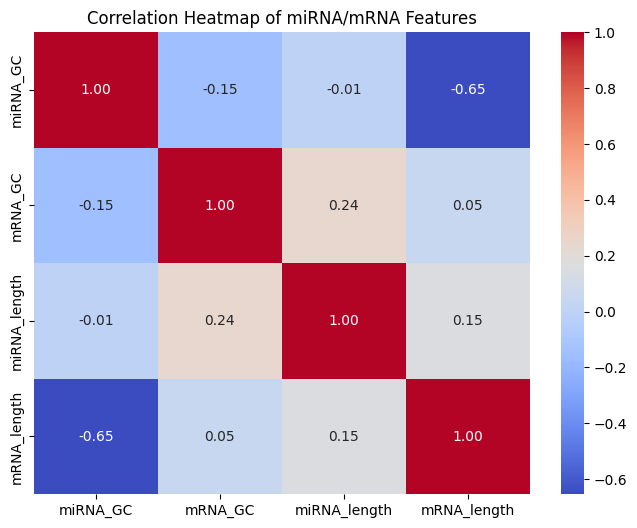

In [32]:
correlation_matrix = df[["miRNA_GC", "mRNA_GC", "miRNA_length", "mRNA_length"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of miRNA/mRNA Features")
plt.show()
